# DATA SCIENCE IN MARKETING

1. Giải quyết một số vấn đề Tiếp thị bằng Khoa học Dữ liệu và kỹ thuật thống kê.
2. Tìm hiểu về quy trình tiếp thị và các Chỉ số hiệu suất chính (KPI) thúc đẩy các nhóm Tiếp thị.

> ***A/B TESTING***



Nguồn dữ liệu : https://www.kaggle.com/code/chenwei17557/rfm-customer-segmentation-and-3d-visualization/input
- phần input trong datasource

# **Ý TƯỞNG BỘ DỮ LIỆU / TỪ ĐIỂN DỮ LIỆU**
1. Ý tưởng của bộ dữ liệu :

là phân tích các nhóm, xác định xem quảng cáo có thành công hay không, bao nhiêu công ty có thể kiếm được từ quảng cáo và xem liệu sự khác biệt giữa các nhóm có ý nghĩa thống kê hay không.

2. Từ điển dữ liệu:

Index: Chỉ số dòng

user id: Mã người dùng (duy nhất)

test group: Nếu là "ad" thì người đó đã xem quảng cáo, nếu là "psa" thì họ chỉ xem thông báo dịch vụ cộng đồng

converted: Nếu người đó mua sản phẩm thì là True, ngược lại là False

total ads: Số lượng quảng cáo mà người đó đã xem

most ads day: Ngày mà người đó xem số lượng quảng cáo lớn nhất

most ads hour: Giờ trong ngày mà người đó xem số lượng quảng cáo lớn nhất

# **Import thư viện**

In [3]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import math
import seaborn as sns

# **Tải file**

In [4]:
df = pd.read_csv('marketing_AB.csv')

In [5]:
df.head()

,Unnamed: 0,user id,test group,converted,total ads,most ads day,most ads hour
0,0,1069124,ad,False,130,Monday,20
1,1,1119715,ad,False,93,Tuesday,22
2,2,1144181,ad,False,21,Tuesday,18
3,3,1435133,ad,False,355,Tuesday,10
4,4,1015700,ad,False,276,Friday,14


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 588101 entries, 0 to 588100
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   Unnamed: 0     588101 non-null  int64 
 1   user id        588101 non-null  int64 
 2   test group     588101 non-null  object
 3   converted      588101 non-null  bool  
 4   total ads      588101 non-null  int64 
 5   most ads day   588101 non-null  object
 6   most ads hour  588101 non-null  int64 
dtypes: bool(1), int64(4), object(2)
memory usage: 27.5+ MB


# **Làm sạch dữ liệu**

In [7]:
df.rename(columns=lambda x: x.strip().replace(" ", "_"), inplace=True)
df.head(1)

,Unnamed:_0,user_id,test_group,converted,total_ads,most_ads_day,most_ads_hour
0,0,1069124,ad,False,130,Monday,20


In [8]:
if "Unnamed: 0" in df.columns:
    df = df.drop(["Unnamed: 0"], axis =1)

In [9]:
df.drop_duplicates()

,Unnamed:_0,user_id,test_group,converted,total_ads,most_ads_day,most_ads_hour
0,0,1069124,ad,False,130,Monday,20
1,1,1119715,ad,False,93,Tuesday,22
2,2,1144181,ad,False,21,Tuesday,18
3,3,1435133,ad,False,355,Tuesday,10
4,4,1015700,ad,False,276,Friday,14
...,...,...,...,...,...,...,...
588096,588096,1278437,ad,False,1,Tuesday,23
588097,588097,1327975,ad,False,1,Tuesday,23
588098,588098,1038442,ad,False,3,Tuesday,23
588099,588099,1496395,ad,False,1,Tuesday,23


In [10]:
df[df["user_id"].duplicated()].count()

Unnamed:_0       0
user_id          0
test_group       0
converted        0
total_ads        0
most_ads_day     0
most_ads_hour    0
dtype: int64

In [11]:
df.isnull().any()

Unnamed:_0       False
user_id          False
test_group       False
converted        False
total_ads        False
most_ads_day     False
most_ads_hour    False
dtype: bool

In [12]:
print(f'Rows            : {df.shape[0]}')
print(f'Columns         : {df.shape[1]}')
print(f'Features        : {df.columns.tolist()}')
print(f'Missing Values  : {df.isnull().values.sum()}')
print(f'Unique Values   : \n\n{df.nunique()}')

Rows            : 588101
Columns         : 7
Features        : ['Unnamed:_0', 'user_id', 'test_group', 'converted', 'total_ads', 'most_ads_day', 'most_ads_hour']
Missing Values  : 0
Unique Values   : 

Unnamed:_0       588101
user_id          588101
test_group            2
converted             2
total_ads           807
most_ads_day          7
most_ads_hour        24
dtype: int64


# **Cân bằng dữ liệu**

In [13]:
from sklearn.utils import resample

# Tách dữ liệu thành hai nhóm: ad và psa
ad_group = df[df['test_group'] == 'ad']
psa_group = df[df['test_group'] == 'psa']

# Undersampling nhóm ad để cân bằng số lượng với nhóm psa
ad_undersampled = resample(ad_group, replace=False, n_samples=len(psa_group), random_state=42)

# Kết hợp lại hai nhóm
balanced_df = pd.concat([ad_undersampled, psa_group])

# **EDA**

In [14]:
def val_count(column, position):
    ax = plt.subplot(1, 3, position)
    sns.countplot(data=df, x=column, ax=ax)
    plt.title(f'Value Count - {column}')

    # Add annotations (rounded integers) on top of each bar
    for p in ax.patches:
        height = int(round(p.get_height()))
        ax.annotate(f'{height}', (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='center', xytext=(0, 10), textcoords='offset points')

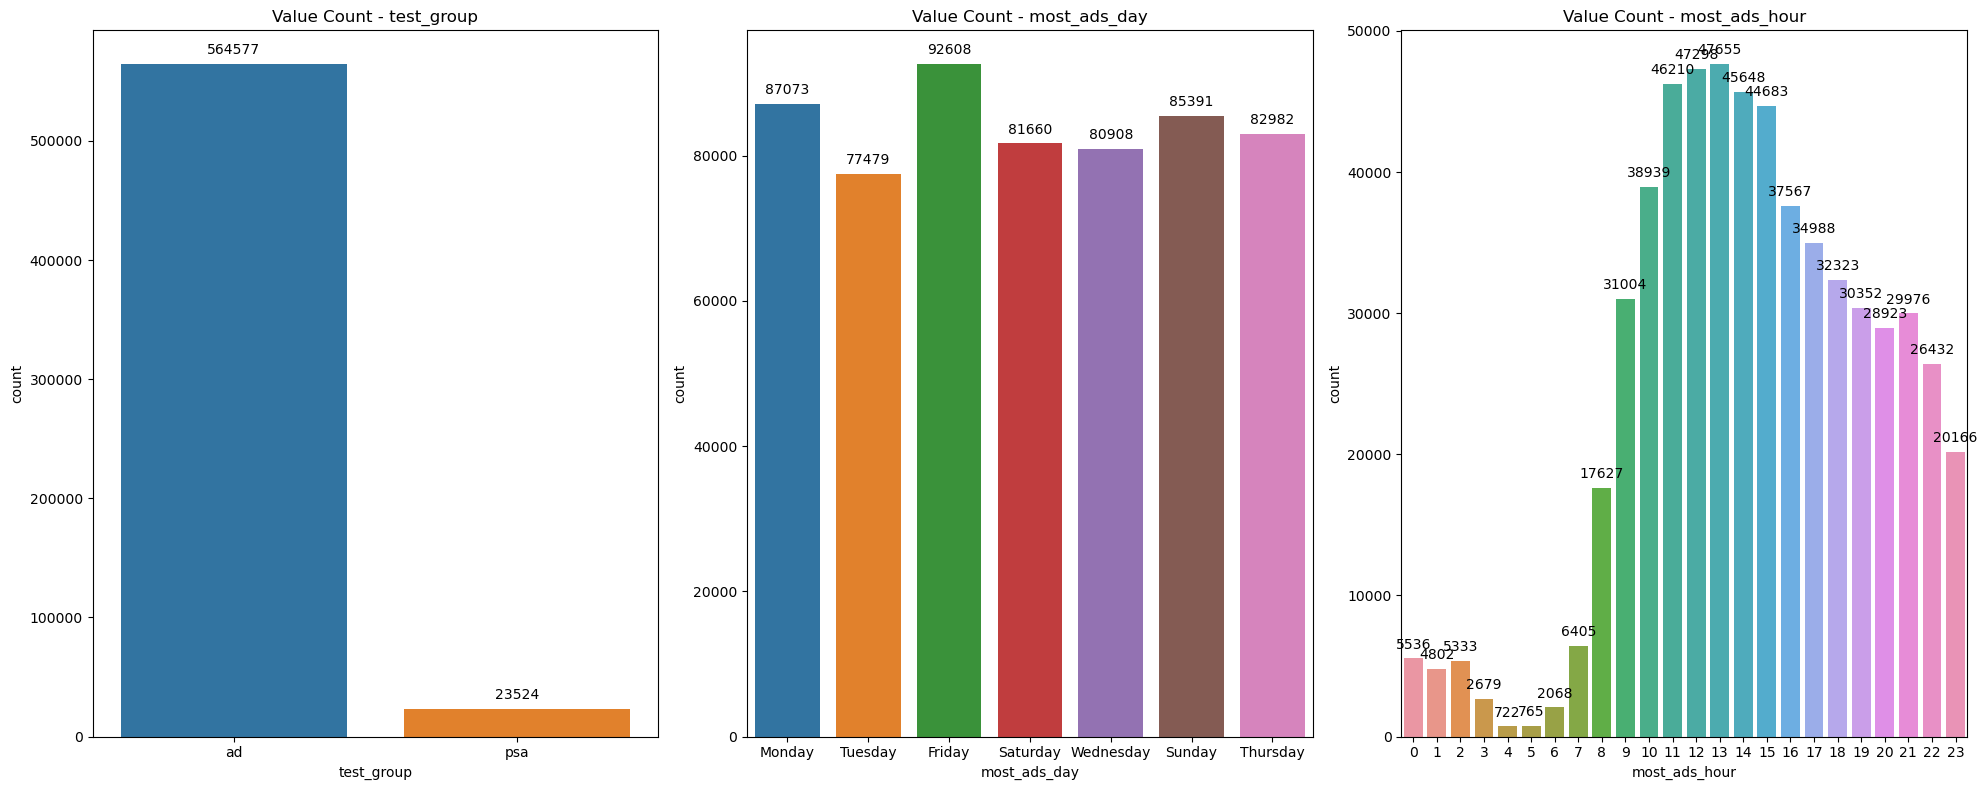

In [15]:
#tạo danh sách cột trong df
col_lst = df.columns[[2,5,6]]

plt.figure(figsize=(20, 8))
for i, col in enumerate(col_lst, start=1):
    val_count(col, i)

plt.tight_layout()
plt.show()

In [16]:
def val_count_balanced(column, position):
    ax = plt.subplot(1, 3, position)
    sns.countplot(data=balanced_df, x=column, ax=ax)
    plt.title(f'Value Count - {column}')

    # Add annotations (rounded integers) on top of each bar
    for p in ax.patches:
        height = int(round(p.get_height()))
        ax.annotate(f'{height}', (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='center', xytext=(0, 10), textcoords='offset points')

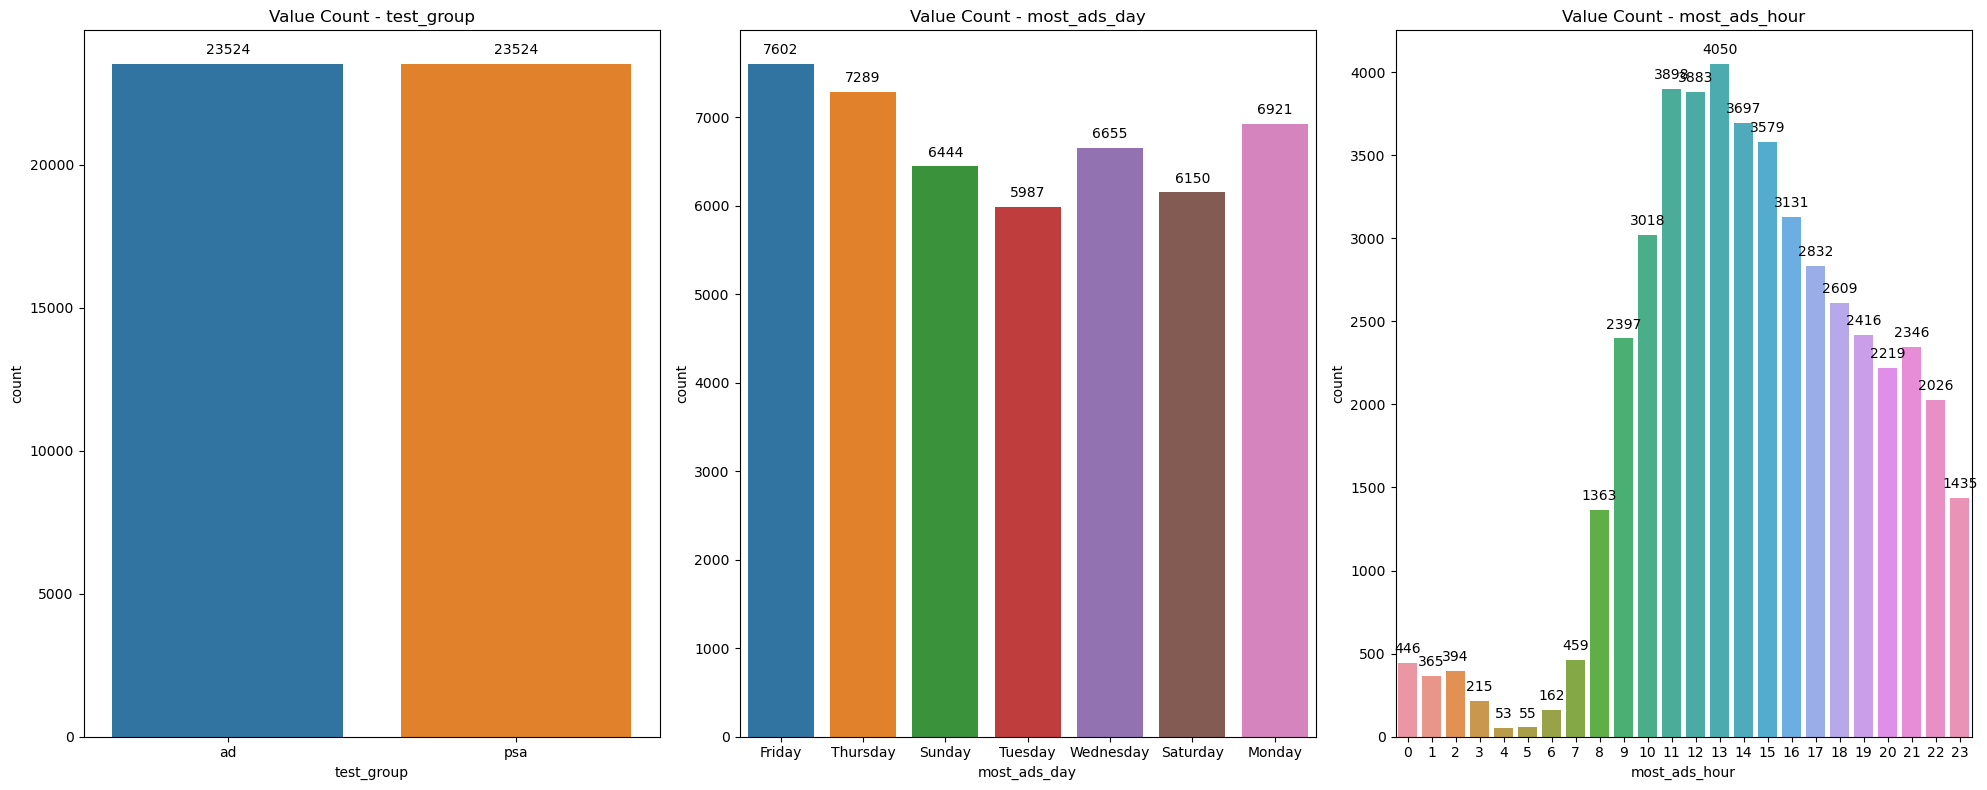

In [17]:
#tạo danh sách cột trong balanced_df
col_lst_0 = balanced_df.columns[[2,5,6]]

plt.figure(figsize=(20, 8))
for i, col in enumerate(col_lst_0, start=1):
    val_count_balanced(col, i)

plt.tight_layout()
plt.show()

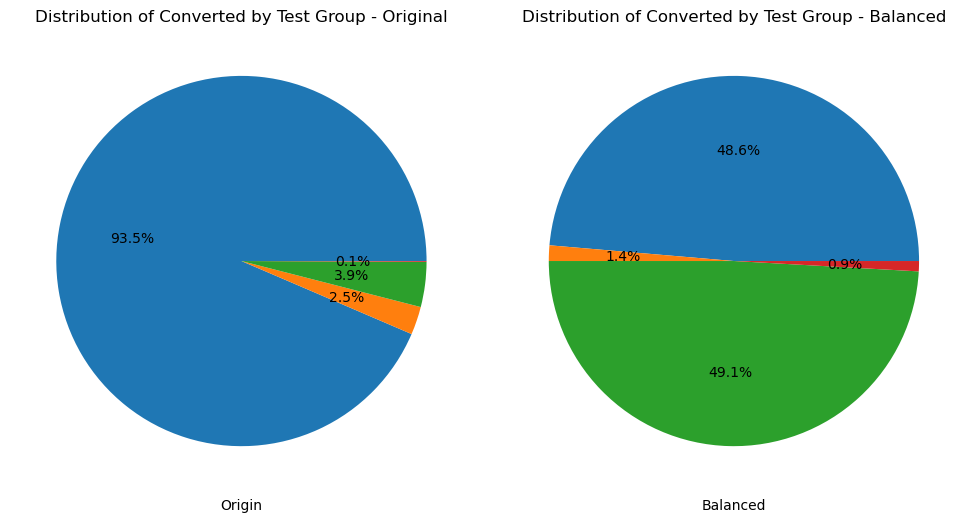

In [18]:
grouped_counts_df = df.groupby('test_group')['converted'].value_counts()
grouped_counts_balanced = balanced_df.groupby('test_group')['converted'].value_counts()

# Tạo subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Đồ thị data dạng pie cho df
axes[0].pie(grouped_counts_df, autopct='%1.1f%%')
axes[0].set_title('Distribution of Converted by Test Group - Original')
axes[0].set_xlabel('Origin')
axes[0].set_ylabel('')

# Đồ thị data dạng pie cho balanced_df
axes[1].pie(grouped_counts_balanced, autopct='%1.1f%%')
axes[1].set_title('Distribution of Converted by Test Group - Balanced')
axes[1].set_xlabel('Balanced')

plt.tight_layout()
plt.show()


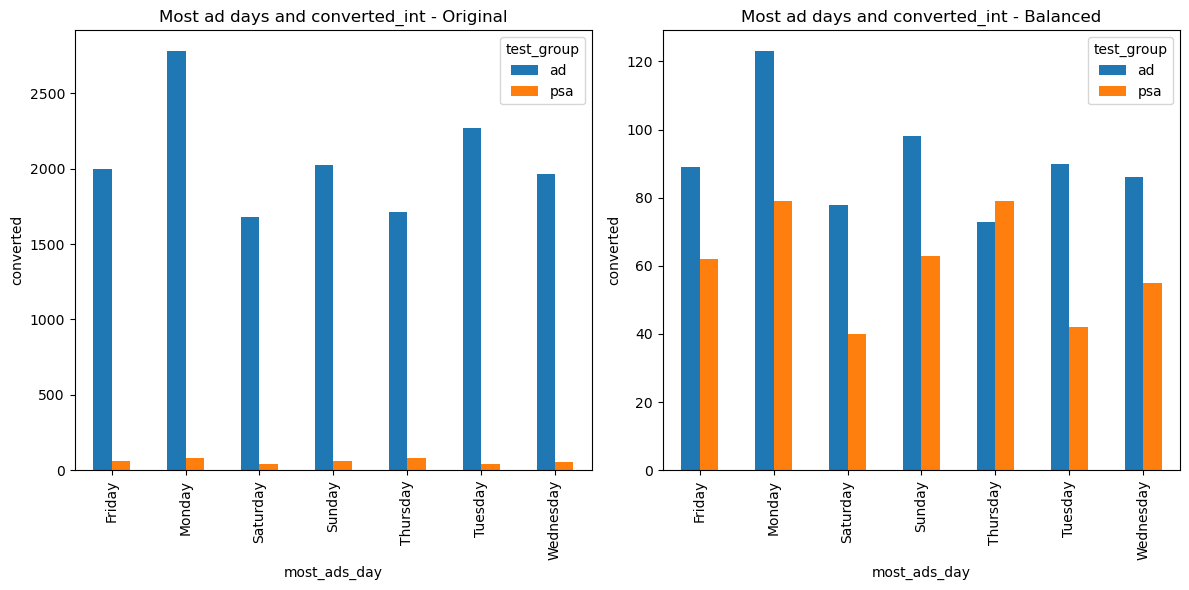

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# đồ thị chuyển đổi của ad trong ngày cho df
ax_df = df.groupby(by=['most_ads_day', 'test_group']).sum()['converted'].unstack('test_group').plot(kind='bar', ax=axes[0])
ax_df.set_ylabel('converted')
ax_df.set_title('Most ad days and converted_int - Original')

# đồ thị chuyển đổi của ad trong ngày cho balanced_df
ax_balanced = balanced_df.groupby(by=['most_ads_day', 'test_group']).sum()['converted'].unstack('test_group').plot(kind='bar', ax=axes[1])
ax_balanced.set_ylabel('converted')
ax_balanced.set_title('Most ad days and converted_int - Balanced')

plt.tight_layout()
plt.show()


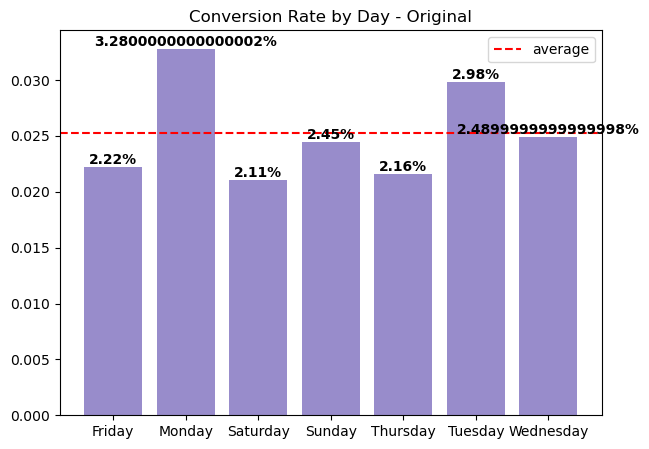

In [20]:
#Trực quan sự chuyển đổi theo ngày - Original
df_day_conv = pd.DataFrame(df.groupby('most_ads_day')['converted'].mean())
df_day_conv.reset_index(inplace=True)
c = (0.2, 0.1, 0.6, .5)

# tạo đồ thị cột
plt.figure(figsize=(7, 5))
bars = plt.bar(data=df_day_conv, x='most_ads_day', height='converted', color=c)

# thêm chú thích số cho từng cột
for bar in bars:
    height = round(bar.get_height(), 4)
    plt.text(bar.get_x() + bar.get_width() / 2, height,
             f'{(height * 100)}%', ha='center', va='bottom', color='black', fontweight='bold')

plt.title('Conversion Rate by Day - Original')
plt.axhline(df_day_conv['converted'].mean(), color='r', linestyle='--', label='average')
plt.legend()
plt.show()

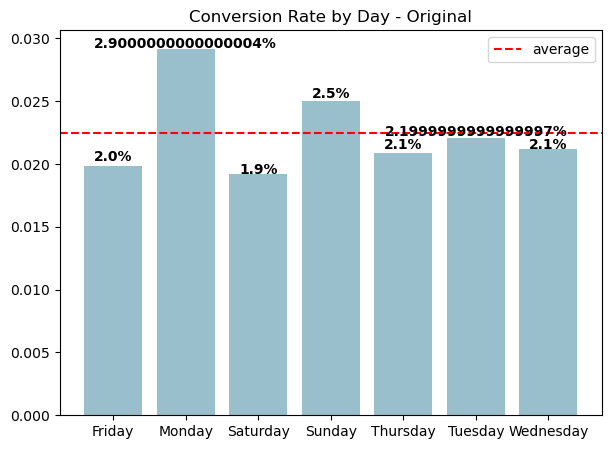

In [21]:
#Trực quan sự chuyển đổi theo ngày - Balanced
df_day_conv = pd.DataFrame(balanced_df.groupby('most_ads_day')['converted'].mean())
df_day_conv.reset_index(inplace=True)
c = (0.2, 0.5, 0.6, .5)

# tạo đồ thị cột
plt.figure(figsize=(7, 5))
bars = plt.bar(data=df_day_conv, x='most_ads_day', height='converted', color=c)

# thêm chú thích số cho từng cột
for bar in bars:
    height = round(bar.get_height(), 3)
    plt.text(bar.get_x() + bar.get_width() / 2, height,
             f'{(height * 100)}%', ha='center', va='bottom', color='black', fontweight='bold')

plt.title('Conversion Rate by Day - Original')
plt.axhline(df_day_conv['converted'].mean(), color='r', linestyle='--', label='average')
plt.legend()
plt.show()

# **AB test**

In [22]:
def sample_size_calculator(population_size, confidence_level, margin_of_error):
    z_score = {
        0.90: 1.645,
        0.95: 1.96,
        0.99: 2.576
    }

    z = z_score[confidence_level]
    p = 0.5
    q = 1 - p

    sample_size = ((z**2) * p * q * population_size) / ((z**2 * q) + ((margin_of_error**2) * (population_size - 1)))
    return math.ceil(sample_size)

In [23]:
# Tính toán kích thước mẫu
pop_size = balanced_df.shape[0]
conf_level = 0.99
margin_err = 0.03

# Gọi hàm tính kích thước mẫu
sample_size = sample_size_calculator(pop_size, conf_level, margin_err)

print(f"The population size is :{pop_size} \nThe required sample size is: {sample_size}")

The population size is :47048 
The required sample size is: 1710


In [24]:
treatment = df.query('test_group == "ad"')
control = df.query('test_group == "psa"')

balanced_treatment = balanced_df.query('test_group == "ad"')
balanced_control = balanced_df.query('test_group == "psa"')

In [25]:
print("Total Converted rate:          ", df.converted.mean()*100)
print("Total Balanced_converted rate: ", balanced_df.converted.mean()*100)

Total Converted rate:           2.523886203220195
Total Balanced_converted rate:  2.246641727597347


In [26]:
print("Control_rate:          ", control["converted"].mean()*100)
print("Balanced_control_rate: ", balanced_control["converted"].mean()*100)

Control_rate:           1.785410644448223
Balanced_control_rate:  1.785410644448223


In [27]:
print("Treatment_rate:          ", treatment["converted"].mean()*100)
print("Balanced_treatment_rate: ", balanced_treatment["converted"].mean()*100)

Treatment_rate:           2.5546559636683748
Balanced_treatment_rate:  2.707872810746472


* **Sau khi phân tích dữ liệu, một quan sát đáng chú ý:**
Tỷ lệ chuyển đổi trung bình trong nhóm Treatment vượt qua tỷ lệ của nhóm Control. Quan sát này hỗ trợ giả thuyết rằng quảng cáo có ảnh hưởng tích cực đối với tỷ lệ chuyển đổi. Kết quả sau khi cân bằng dữ liệu đầu vào, mặc dù có sự thay đổi nhỏ, vẫn nhất quán với các kết quả ban đầu. Dữ liệu gợi ý một mối tương quan tiềm năng giữa việc tiếp xúc với quảng cáo và khả năng chuyển đổi tăng lên. Sự thay đổi nhỏ này trong tỷ lệ chuyển đổi trung bình củng cố quan điểm rằng quảng cáo có thể thực sự đang ảnh hưởng tích cực đến hành vi người dùng. Việc phân tích tiếp theo và theo dõi liên tục sẽ giúp xác nhận và điều chỉnh những kết quả này theo thời gian.

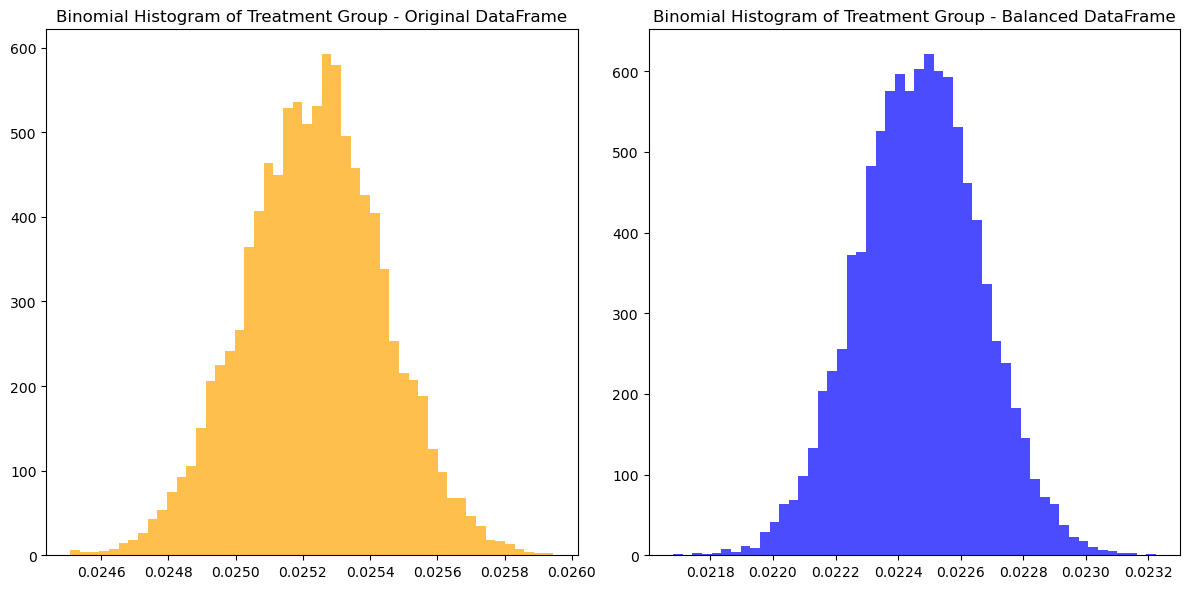

In [28]:
# Dữ liệu mô phỏng từ balanced_df
ad_converted_balanced = np.random.binomial(len(treatment), balanced_df.converted.mean(), 10000) / len(treatment)

# Dữ liệu mô phỏng từ df
ad_converted_original = np.random.binomial(len(treatment), df.converted.mean(), 10000) / len(treatment)

plt.figure(figsize=(12, 6))

# Vẽ histogram cho df
plt.subplot(1, 2, 1)
plt.hist(ad_converted_original, bins=50, color='orange', alpha=0.7)
plt.title('Binomial Histogram of Treatment Group - Original DataFrame')

# Vẽ histogram cho balanced_df
plt.subplot(1, 2, 2)
plt.hist(ad_converted_balanced, bins=50, color='blue', alpha=0.7)
plt.title('Binomial Histogram of Treatment Group - Balanced DataFrame')

plt.tight_layout()
plt.show()

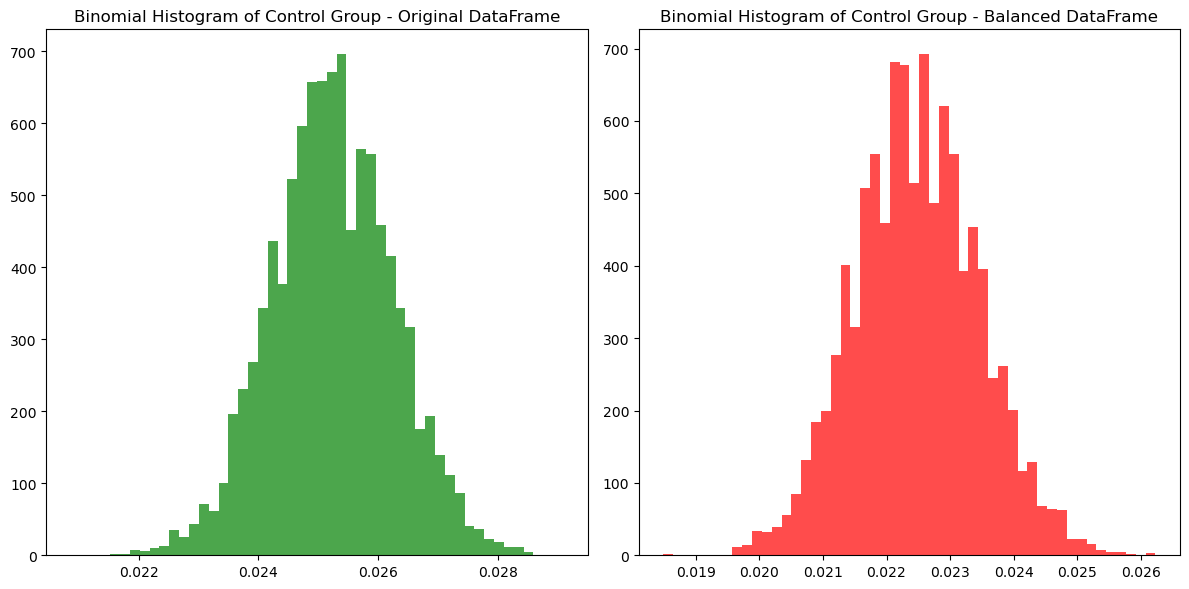

In [29]:
# Dữ liệu mô phỏng từ balanced_df
psa_converted_balanced = np.random.binomial(len(control), balanced_df.converted.mean(), 10000) / len(control)

# Dữ liệu mô phỏng từ df
psa_converted_original = np.random.binomial(len(control), df.converted.mean(), 10000) / len(control)

plt.figure(figsize=(12, 6))

# Vẽ histogram cho df
plt.subplot(1, 2, 1)
plt.hist(psa_converted_original, bins=50, color='green', alpha=0.7)
plt.title('Binomial Histogram of Control Group - Original DataFrame')

# Vẽ histogram cho balanced_df
plt.subplot(1, 2, 2)
plt.hist(psa_converted_balanced, bins=50, color='red', alpha=0.7)
plt.title('Binomial Histogram of Control Group - Balanced DataFrame')


plt.tight_layout()
plt.show()

***Việc hiển thị quảng cáo cho người dùng có dẫn đến việc mua sắm nhiều hơn không? Có ý nghĩa thống kê hay không?***
* (H0): Việc hiển thị quảng cáo không có ảnh hưởng đáng kể đến số lượng mua sắm.
* (H1): Việc hiển thị quảng cáo có ảnh hưởng đáng kể đến số lượng mua sắm.

In [30]:
# Dữ liệu mô phỏng từ df
ad_converted_df = np.random.binomial(len(treatment), df.converted.mean(), 10000) / len(treatment)

# Dữ liệu mô phỏng từ balanced_df
ad_converted_balanced_df = np.random.binomial(len(treatment), balanced_df.converted.mean(), 10000) / len(treatment)

# Tính hiệu quả thực tế giữa treatment và control
ab_data_diff_df = df['converted'].mean() - control['converted'].mean()
ab_data_diff_balanced_df = balanced_df['converted'].mean() - control['converted'].mean()

# Tính sự khác biệt giữa ad_converted và psa_converted
p_diffs_df = ad_converted_df - psa_converted_original
p_diffs_balanced_df = ad_converted_balanced_df - psa_converted_balanced

# Tính giá trị p cho df
if ab_data_diff_df > 0:
    p_value_df = (p_diffs_df > ab_data_diff_df).mean() * 100
else:
    p_value_df = (p_diffs_df <= ab_data_diff_df).mean() * 100

# Tính giá trị p cho balanced_df
if ab_data_diff_balanced_df > 0:
    p_value_balanced_df = (p_diffs_balanced_df > ab_data_diff_balanced_df).mean() * 100
else:
    p_value_balanced_df = (p_diffs_balanced_df <= ab_data_diff_balanced_df).mean() * 100

# So sánh kết quả với df
print("Results with df:")
print("p_value =", p_value_df)
if p_value_df < 0.05:
    print('Có sự khác biệt đáng kể giữa hai nhóm.')
else:
    print('Không có sự khác biệt đáng kể giữa hai nhóm.')

# So sánh kết quả với balanced_df
print("\nResults with balanced_df:")
print("p_value =", p_value_balanced_df)
if p_value_balanced_df < 0.05:
    print('Có sự khác biệt đáng kể giữa hai nhóm.')
else:
    print('Không có sự khác biệt đáng kể giữa hai nhóm.')


Results with df:
p_value = 0.0
Có sự khác biệt đáng kể giữa hai nhóm.

Results with balanced_df:
p_value = 0.0
Có sự khác biệt đáng kể giữa hai nhóm.


***Có thể kết luận rằng*** sự can thiệp mà ta đang xem xét có tác động đáng kể và tích cực đến tỷ lệ chuyển đổi. Cả trong tập dữ liệu ban đầu (df) và tập dữ liệu cân bằng (balanced_df), giá trị p là 0.0, chỉ ra rằng có sự khác biệt thống kê đáng kể giữa các nhóm được xem xét. Điều này chứng minh rằng can thiệp không chỉ ảnh hưởng tích cực đến tỷ lệ chuyển đổi mà còn đảm bảo tính ổn định và nhất quán của kết quả qua các tập dữ liệu khác nhau. Do đó, can thiệp này có thể xem là một phương pháp hiệu quả để cải thiện kết quả mong muốn.

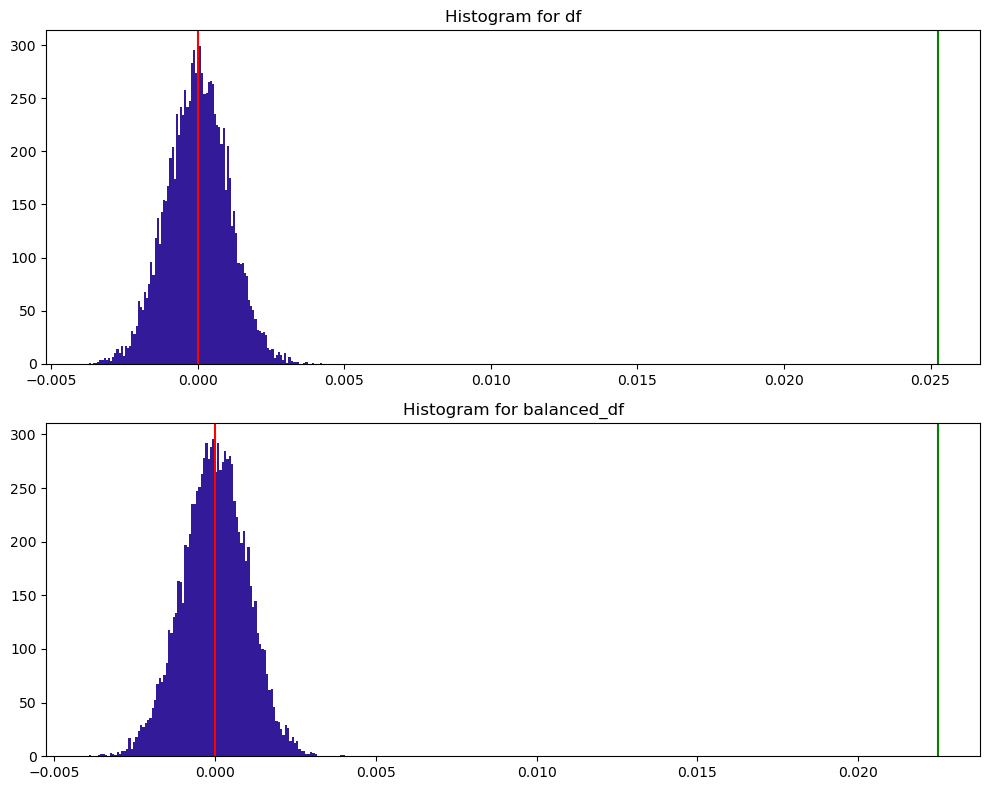

In [31]:
c = (0.2, 0.1, 0.6, 1)

# tạo subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# Histogram cho p_diffs_df
ax1.hist(p_diffs_df, bins=110, color=c)
low_mean_df = ad_converted_df.mean()
high_mean_df = p_diffs_df.mean()
ax1.axvline(x=low_mean_df, color='g')
ax1.axvline(x=high_mean_df, color='r')
ax1.set_title("Histogram for df")

# Histogram cho p_diffs_balanced_df
ax2.hist(p_diffs_balanced_df, bins=110, color=c)
low_mean_balanced = ad_converted_balanced_df.mean()
high_mean_balanced = p_diffs_balanced_df.mean()
ax2.axvline(x=low_mean_balanced, color='g')
ax2.axvline(x=high_mean_balanced, color='r')
ax2.set_title("Histogram for balanced_df")

plt.tight_layout()
plt.show()

Dựa trên biểu đồ histogram được cung cấp, có thể rút ra một số quan sát và kết luận sau:
- Cả hai đều có dạng phân phối chuẩn, với hình dạng đường cong hình chuông.
- Bộ dữ liệu df có phân phối hơi lệch về bên trái (lệch âm), với đuôi phân phối mở rộng hơn ở bên trái của đỉnh.
- Đường thẳng đỏ trong histogram của df biểu diễn trung bình của bộ dữ liệu. Vì trung bình rất gần với không, điều này cho thấy dữ liệu tập trung xung quanh không.
- Bộ dữ liệu balanced_df có phân phối đối xứng hơn so với df, có thể do kỹ thuật cân bằng *Undersample* đã được áp dụng.
- Trung bình của balanced_df cũng được biểu diễn bằng một đường thẳng đỏ và được đặt tại không, tương tự như df.
- Sự phân tán (phương sai) của cả hai bộ dữ liệu có vẻ tương tự, với chiều rộng của đường cong chuông xấp xỉ nhau.
- Đỉnh của cả hai histogram tương đối cao và tương tự nhau, cho thấy giá trị thường xuất hiện nhất trong cả hai bộ dữ liệu là xung quanh không.

Kết luận, bộ dữ liệu df có vẻ lệch nhẹ về bên trái, trong khi balanced_df dường như đã được điều chỉnh để giảm thiểu sự lệch này và có phân phối đối xứng hơn xung quanh trung bình. Cả hai bộ dữ liệu đều có trung bình tại hoặc gần không và có sự phân tán dữ liệu tương tự nhau.

# **Kết luận**

1. Quan sát từ dữ liệu cho thấy tỷ lệ chuyển đổi trung bình trong nhóm Treatment cao hơn nhóm Control. Điều này ủng hộ giả thuyết rằng quảng cáo có tác động tích cực đến tỷ lệ chuyển đổi. Kết quả này vẫn nhất quán ngay cả sau khi cân bằng dữ liệu, gợi ý mối liên hệ giữa việc tiếp xúc với quảng cáo và khả năng chuyển đổi cao hơn.

2. Kiểm định giả thuyết nhằm xác định liệu việc hiển thị quảng cáo có dẫn đến nhiều mua hàng hơn và có ý nghĩa thống kê hay không. Giả thuyết không (H0) cho rằng việc hiển thị quảng cáo không có ảnh hưởng đáng kể đến số lượng mua hàng, trong khi giả thuyết khác (H1) cho rằng có ảnh hưởng.

3. Kết luận rằng can thiệp đang xem xét có ảnh hưởng đáng kể và tích cực đến tỷ lệ chuyển đổi. Trong cả bộ dữ liệu gốc (df) và bộ dữ liệu cân bằng (balanced_df), giá trị p là 0.0, chỉ ra sự khác biệt có ý nghĩa thống kê giữa các nhóm. Điều này chứng minh rằng can thiệp không chỉ tác động tích cực đến tỷ lệ chuyển đổi mà còn đảm bảo tính ổn định và nhất quán của kết quả qua các tập dữ liệu khác nhau.

4. Histogram cung cấp cái nhìn vào phân phối dữ liệu, với cả hai bộ dữ liệu hiển thị hình dạng phân phối chuẩn. Bộ dữ liệu `df` hơi lệch trái, trong khi `balanced_df` có phân phối đối xứng hơn xung quanh trung bình, do kỹ thuật cân bằng như undersampling.

Tóm lại, A/B testing đã thực hiện cho thấy rằng can thiệp quảng cáo có tác động tích cực và có ý nghĩa thống kê đến tỷ lệ chuyển đổi của người dùng. Sự nhất quán của tác động này qua các tập dữ liệu khác nhau củng cố thêm tính hợp lệ của nó. Khuyến nghị thêm phân tích và theo dõi liên tục để đảm bảo hiệu quả lâu dài của chiến lược quảng cáo.